<a href="https://colab.research.google.com/github/Nightyelf2403/Nightyelf2403.github.io-Cs360Lab_2/blob/main/White_Box_Evasion_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install tensorflow 2.15.0
# Note: tensorflow 2.17.0 is preinstalled in Google Colab
# however, there are compatibility issues between version 2.17.0 and the ART library
# therefore, this line will uninstall tensorflow 2.17.0 and wil install version 2.15.0
!pip install -q tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.71 requires ml_dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.


In [ ]:
# Install the ART library (provides adversarial attacks)
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.4 MB/s eta 0:00:00


In [ ]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import cv2
import natsort
import tarfile
from sklearn.model_selection import train_test_split

# This line is important, without it the attacks in the ART toolbox won't work
# when using the Keras ART classifier
# And it needs to be run before training the models
tf.compat.v1.disable_eager_execution()

# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))

TensorFlow version:2.15.0


In [ ]:
# Uncompress the Imagenette dataset
# (Obviously, replace the path to the folder on Google drive where you saved the dataset)
tar = tarfile.open('/content/drive/MyDrive/imagenette2-160.tgz', 'r:gz')
for item in tar:
    tar.extract(item)

In [ ]:
# Function to load the images and the labels from the dataset
def load_images_and_labels(directory):

    imgs_list = []
    labels_list = []

    # List of all subfolders in the directory
    subfolders_list_1 = listdir(directory)
    # Make sure that the subfolders are sorted
    subfolders_list = natsort.natsorted(subfolders_list_1)

    # Assign a label to each folder with images (0 to the first folder)
    lab = 0
    for subfolder_name in subfolders_list:
            sub_dir_path = directory + '/' + subfolder_name
            if subfolder_name != '.DS_Store':

                # Read the images as numpy arrays
                imagesList = listdir(sub_dir_path)
                for i in range(len(imagesList)):
                  tmp_img = cv2.imread(os.path.join(sub_dir_path, imagesList[i]))
                  # Resize all images to 128 x 128 pixels
                  resized_img = cv2.resize(tmp_img, (128, 128))
                  img_arr = np.array(resized_img)
                  imgs_list.append(img_arr/255.)
                  labels_list.append(lab)
                lab += 1

    # Convert the lists to numpy arrays
    imgs = np.asarray(imgs_list)
    labels = np.asarray(labels_list)

    return imgs, labels

# Use the above function to load the training and test datasets
train_images, train_labels = load_images_and_labels('imagenette2-160/train')
test_and_val_images, test_and_val_labels = load_images_and_labels('imagenette2-160/val')

In [ ]:
# Split into test and validation sets
test_images, val_images, test_labels, val_labels = train_test_split(test_and_val_images, test_and_val_labels, test_size=0.4, random_state=12)

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(train_images.shape, train_labels.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(val_images.shape, val_labels.shape))
print('Images test shape: {} - Labels test shape: {}'.format(test_images.shape, test_labels.shape))

# Display the range of images (to make sure they are in the [0, 1] range)
print('\nMax pixel value', np.max(train_images))
print('Min pixel value', np.min(train_images))
print('Average pixel value', np.mean(train_images))
print('Data type', train_images[0].dtype)

Images train shape: (9469, 128, 128, 3) - Labels train shape: (9469,)
Images validation shape: (1570, 128, 128, 3) - Labels validation shape: (1570,)
Images test shape: (2355, 128, 128, 3) - Labels test shape: (2355,)

Max pixel value 1.0
Min pixel value 0.0
Average pixel value 0.4496687819589066
Data type float64


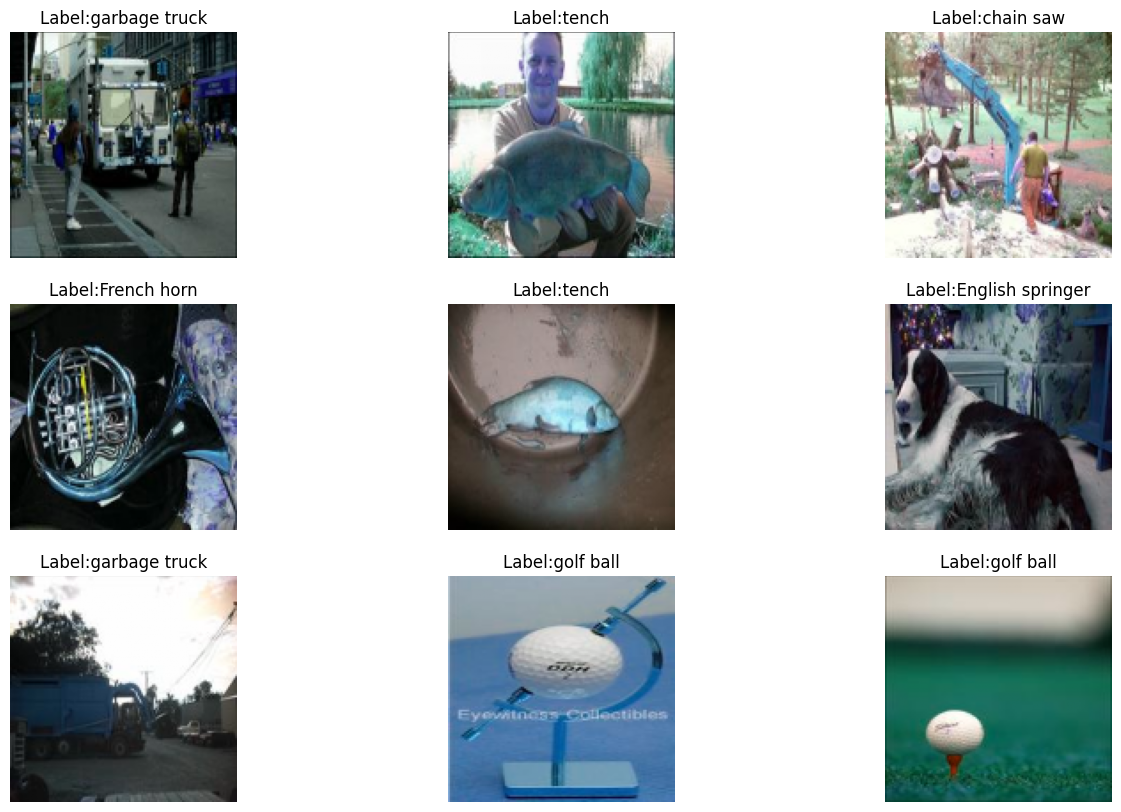

In [ ]:
# A list with the names of the image classes
label_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn',  'garbage truck', 'gas pump', 'golf ball', 'parachute']

# Plot a few images to check if the labels make sense
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(train_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(train_images[i[0]])
    plt.title('Label:' + str(label_names[train_labels[i[0]]]))
    plt.axis('off')

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import vgg16

import datetime
now = datetime.datetime.now

In [ ]:
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Add fully-connected layers
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
# Add a softmax layer with 10 classes
predictions = Dense(10, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

58889256/58889256 [==============================] - 2s 0us/step


In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

# Fit model
t = now()
history = model.fit(train_images, train_labels, epochs=100, batch_size=32,
                     validation_data=[val_images, val_labels], verbose=1, callbacks=callbacks)
print('Training time: %s' % (now() - t))

Train on 9469 samples, validate on 1570 samples
Epoch 1/100


KeyboardInterrupt: 

In [ ]:
# Plot the loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# Evaluate on test images
evals_test = model.evaluate(test_images, test_labels)
print("Classification Accuracy: ", evals_test[1])

# Non-targeted Adversarial Attacks

In [ ]:
# Import the KerasClassifier from the ART library
# Import the FastGradientMethod and ProjectedGradientDescent attacks from the ART library
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

In [ ]:
# Create a KerasClassifier object for the model, clip input values to the range [0, 1]
classifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits=True)

In [ ]:
# Use the first 200 test images for creating adversarial samples
adv_imgs = test_images[0:200]
adv_labels = test_labels[0:200]

In [ ]:
# FGSM attack for the first few images with espilon=30./255
attack_fgsm = FastGradientMethod(estimator=classifier, eps=30./255)
fgsm_attack_adv_imgs = attack_fgsm.generate(adv_imgs[0:10])
plt.matshow(np.squeeze(fgsm_attack_adv_imgs[0]))
plt.show()

In [ ]:
# FGSM attack with espilon=10./155
attack_fgsm = FastGradientMethod(estimator=classifier, eps=10./255)
fgsm_attack_adv_imgs = attack_fgsm.generate(adv_imgs)
loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_imgs, adv_labels)
perturbation = np.mean(np.abs((fgsm_attack_adv_imgs - adv_imgs)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))
plt.matshow(np.squeeze(fgsm_attack_adv_imgs[0]))
plt.show()

In [ ]:
# FGSM attack for various epsilon values
epsilon = [0./255, 1./255, 3./255, 5./255, 8./255, 20./255, 50./255, 80./255]

fgsm_attack_acc = []
for eps in epsilon:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)
    fgsm_attack_adv_imgs = attack_fgsm.generate(adv_imgs)
    loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_imgs, adv_labels)
    fgsm_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((fgsm_attack_adv_imgs - adv_imgs)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    plt.matshow(np.squeeze(fgsm_attack_adv_imgs[0]))
    plt.show()

In [ ]:
# PGD attack

pgd_attack_acc = []
for eps in epsilon:
    attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=eps)
    pgd_attack_adv_imgs = attack_pgd.generate(adv_imgs)
    loss_test, accuracy_test = model.evaluate(pgd_attack_adv_imgs, adv_labels)
    pgd_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((pgd_attack_adv_imgs - adv_imgs)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    plt.matshow(np.squeeze(pgd_attack_adv_imgs[0]))
    plt.show()

# Targeted Adversarial Attack

In [ ]:
# Collect all "Church" images from the dataset
church_images_list = []
for i, label in enumerate(test_labels):
  if label==4:
      church_images_list.append(test_images[i])

church_images = np.asarray(church_images_list)

print(church_images.shape)

In [ ]:
# Plot a few images to check if the labels are accurate
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(church_images), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(church_images[i[0]])
    plt.axis('off')

In [ ]:
# Target labels are "Gas pump" (class label is 7)
labels_target = 7*np.ones((len(church_images),1))

In [ ]:
labels_target.shape

In [ ]:
# Church labels
labels_church = 4*np.ones((len(church_images),1))

In [ ]:
# Evaluate the accuracy of the model on the set of church images
loss_test, accuracy_test = model.evaluate(np.array(church_images), labels_church)
print('Accuracy on clean test data: {:4.2f}%'.format(accuracy_test * 100))

In [ ]:
# FGSM targetted attack

epsilon = [0./255, 1./255, 3./255, 5./255, 8./255, 20./255, 50./255, 80./255]

fgsm_target_attack_acc = []

for eps in epsilon:
    attack_fgsm_tar = FastGradientMethod(estimator=classifier, eps=eps, targeted=True)
    fgsm_attack_adv_imgs_tar = attack_fgsm_tar.generate(church_images, labels_target)
    loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_imgs_tar, labels_target)
    fgsm_target_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((fgsm_attack_adv_imgs_tar - church_images)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))

    preds = model.predict(fgsm_attack_adv_imgs_tar)
    print('Predicted class:', np.argmax(preds, axis=-1))

    loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_imgs_tar, labels_church)
    print('Accuracy on church labels: {:4.2f}%'.format(accuracy_test * 100))

    print('Predicted as target labels: {:4.2f}%'.format(100*np.sum(np.argmax(preds, axis=-1)==7)/len(labels_target)))

    plt.matshow(np.squeeze(fgsm_attack_adv_imgs_tar[0]))
    plt.show()

In [ ]:
# PGD targetted attack

pgd_target_attack_acc = []
for eps in epsilon:
    attack_pgd_tar = ProjectedGradientDescent(estimator=classifier, eps=eps, targeted=True, verbose=False)
    pgd_attack_adv_imgs_tar = attack_pgd_tar.generate(church_images, labels_target)
    loss_test, accuracy_test = model.evaluate(pgd_attack_adv_imgs_tar, labels_target)
    pgd_target_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((pgd_attack_adv_imgs_tar - church_images)))

    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))

    preds = model.predict(pgd_attack_adv_imgs_tar)
    print('Predicted class:', np.argmax(preds, axis=-1))

    loss_test, accuracy_test = model.evaluate(pgd_attack_adv_imgs_tar, labels_church)
    print('Accuracy on church labels: {:4.2f}%'.format(accuracy_test * 100))

    print('Predicted as target labels: {:4.2f}%'.format(100*np.sum(np.argmax(preds, axis=-1)==7)/len(labels_target)))

    print(10*'*')

    plt.matshow(np.squeeze(pgd_attack_adv_imgs_tar[0]))
    plt.show()

print('Training time: %s' % (now() - t))